In [7]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install imblearn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


🚀 FRAUD DETECTION TRAINING PIPELINE

📊 LOADING FRAUD DATASET
🔍 Auto-detecting dataset path...
✅ Found dataset at: ../data/fraud_dataset.csv
✅ Loaded as CSV
📊 Shape: (50000, 21)
📁 File path used: ../data/fraud_dataset.csv

📋 Available columns (21):
    1. Transaction_ID
    2. User_ID
    3. Transaction_Amount
    4. Transaction_Type
    5. Timestamp
    6. Account_Balance
    7. Device_Type
    8. Location
    9. Merchant_Category
   10. IP_Address_Flag
   11. Previous_Fraudulent_Activity
   12. Daily_Transaction_Count
   13. Avg_Transaction_Amount_7d
   14. Failed_Transaction_Count_7d
   15. Card_Type
   16. Card_Age
   17. Transaction_Distance
   18. Authentication_Method
   19. Risk_Score
   20. Is_Weekend
   21. Fraud_Label

📈 Dataset Summary:
   • Target Column: Fraud_Label
   • Total Transactions: 50,000
   • Fraud Rate: 32.1%
   • Fraudulent: 16,067
   • Legitimate: 33,933

🔧 FEATURE ENGINEERING
🗑️ Removing ID columns: ['Transaction_ID', 'User_ID']
⏰ Processing timestamp feature

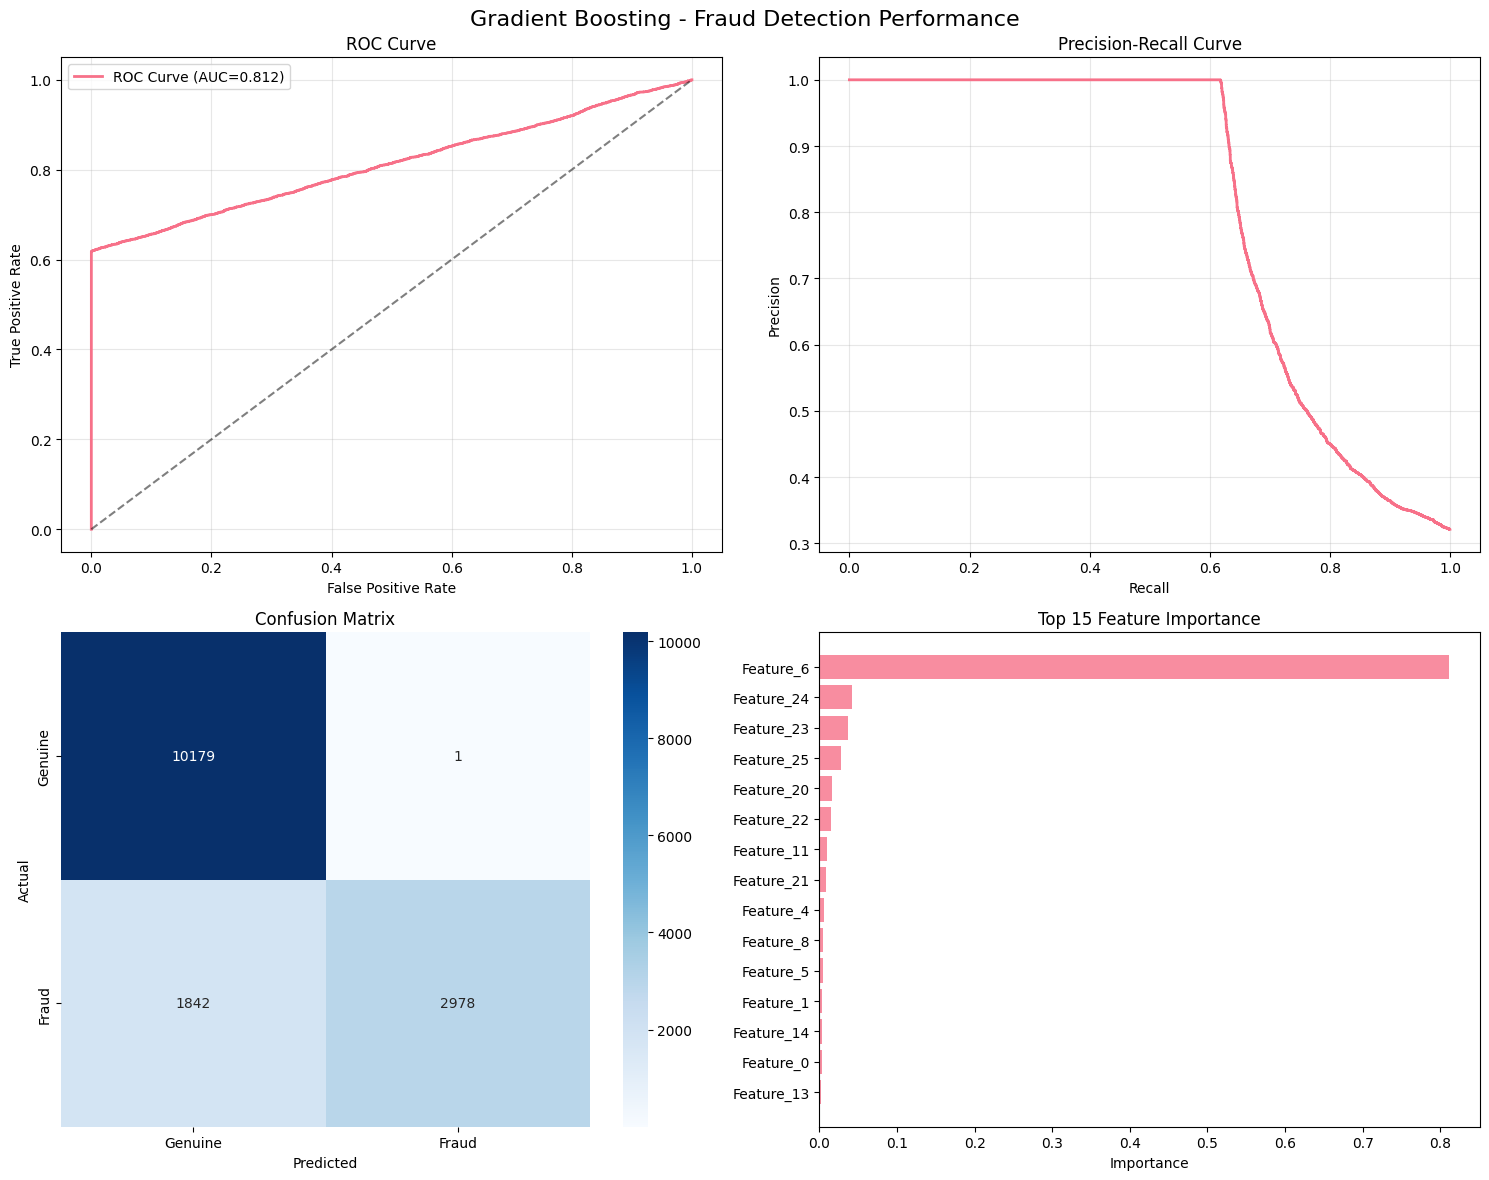


💾 SAVING MODEL ARTIFACTS FOR DEPLOYMENT
✅ Model saved: deployment_artifacts\gradient_boosting_model.joblib
✅ Scaler saved: deployment_artifacts\feature_scaler.joblib
✅ Feature names saved: deployment_artifacts\feature_names.joblib
✅ Metadata saved: deployment_artifacts\model_metadata.joblib

📁 All artifacts saved in: deployment_artifacts/
Ready for deployment! 🚀

🎉 TRAINING COMPLETED!
🏆 Final Performance:
   • F1-Score: 0.7637
   • Precision: 0.9997
   • Recall: 0.6178
   • ROC-AUC: 0.8120

📁 Model artifacts saved in: deployment_artifacts/
🚀 Ready for deployment!

✅ Training pipeline completed successfully!
📋 Next steps:
   1. Check deployment_artifacts/ folder
   2. Use deployment scripts for production
   3. Test with sample predictions


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, precision_score, recall_score)

try:
    from imblearn.over_sampling import SMOTE
    HAS_IMBLEARN = True
except ImportError:
    HAS_IMBLEARN = False

import joblib
from datetime import datetime
import os
from collections import Counter

plt.style.use('default')
sns.set_palette("husl")

def load_dataset(file_path=None, target_column='Fraud_Label'):
    """Load fraud dataset with flexible path handling"""
    
    print("\n📊 LOADING FRAUD DATASET")
    print("=" * 35)
    
    # Auto-detect file path if not provided
    if file_path is None:
        possible_paths = [
            '../data/fraud_dataset.csv',
            '../data/fraud_dataset',
            'data/fraud_dataset.csv', 
            'data/fraud_dataset',
            r'C:\Users\Prathamesh\Downloads\Data_Science\Fraud_detection\data\fraud_dataset.csv',
            r'C:\Users\Prathamesh\Downloads\Data_Science\Fraud_detection\data\fraud_dataset'
        ]
        
        print("🔍 Auto-detecting dataset path...")
        for path in possible_paths:
            if os.path.exists(path):
                file_path = path
                print(f"✅ Found dataset at: {file_path}")
                break
        
        if file_path is None:
            print("❌ Dataset not found in any expected location!")
            print("Searched paths:")
            for path in possible_paths:
                print(f"   • {path}")
            return None, None
    
    try:
        # Try different file formats
        if file_path.endswith('.csv') or not os.path.splitext(file_path)[1]:
            try:
                df = pd.read_csv(file_path)
                print(f"✅ Loaded as CSV")
            except:
                # Try without .csv extension if it failed
                if not file_path.endswith('.csv'):
                    df = pd.read_csv(file_path + '.csv')
                    print(f"✅ Loaded as CSV (added .csv extension)")
                else:
                    raise
        elif file_path.endswith(('.xlsx', '.xls')):
            df = pd.read_excel(file_path)
            print(f"✅ Loaded as Excel")
        else:
            # Try CSV first, then Excel
            try:
                df = pd.read_csv(file_path)
                print(f"✅ Loaded as CSV")
            except:
                df = pd.read_excel(file_path)
                print(f"✅ Loaded as Excel")
        
        print(f"📊 Shape: {df.shape}")
        print(f"📁 File path used: {file_path}")
        
        # Display column names to help identify target column
        print(f"\n📋 Available columns ({len(df.columns)}):")
        for i, col in enumerate(df.columns):
            print(f"   {i+1:2d}. {col}")
        
        # Check if target column exists
        if target_column not in df.columns:
            print(f"\n❌ Target column '{target_column}' not found!")
            
            # Suggest similar column names
            similar_cols = [col for col in df.columns if 'fraud' in col.lower() or 'label' in col.lower() or 'target' in col.lower()]
            if similar_cols:
                print(f"🔍 Possible target columns: {similar_cols}")
                # Use the first similar column
                target_column = similar_cols[0]
                print(f"✅ Using '{target_column}' as target column")
            else:
                return None, None
        
        fraud_rate = df[target_column].mean()
        print(f"\n📈 Dataset Summary:")
        print(f"   • Target Column: {target_column}")
        print(f"   • Total Transactions: {len(df):,}")
        print(f"   • Fraud Rate: {fraud_rate:.1%}")
        print(f"   • Fraudulent: {df[target_column].sum():,}")
        print(f"   • Legitimate: {(len(df) - df[target_column].sum()):,}")
        
        return df, target_column
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        print(f"📁 Attempted path: {file_path}")
        print(f"📁 Current working directory: {os.getcwd()}")
        print(f"📁 Files in current directory: {os.listdir('.')}")
        
        # Try to list files in data directory
        data_dirs = ['../data', 'data', r'C:\Users\Prathamesh\Downloads\Data_Science\Fraud_detection\data']
        for data_dir in data_dirs:
            if os.path.exists(data_dir):
                print(f"📁 Files in {data_dir}: {os.listdir(data_dir)}")
                break
        
        return None, None

def feature_engineering(df, target_col='Fraud_Label'):
    """Feature engineering for fraud dataset"""
    
    print("\n🔧 FEATURE ENGINEERING")
    print("=" * 30)
    
    df_processed = df.copy()
    
    # Remove ID columns (prevent data leakage)
    id_columns = ['Transaction_ID', 'User_ID']
    print(f"🗑️ Removing ID columns: {id_columns}")
    df_processed = df_processed.drop(columns=[col for col in id_columns if col in df_processed.columns])
    
    # Handle timestamp features
    if 'Timestamp' in df_processed.columns:
        print("⏰ Processing timestamp features...")
        df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'])
        df_processed['Hour'] = df_processed['Timestamp'].dt.hour
        df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek
        df_processed['IsNight'] = ((df_processed['Hour'] >= 22) | (df_processed['Hour'] <= 6)).astype(int)
        df_processed = df_processed.drop('Timestamp', axis=1)
        print("   ✅ Created: Hour, DayOfWeek, IsNight")
    
    # Remove Risk_Score (potential data leakage)
    if 'Risk_Score' in df_processed.columns:
        print("⚠️ Removing Risk_Score (potential data leakage)")
        df_processed = df_processed.drop('Risk_Score', axis=1)
    
    # Identify feature types
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target from feature lists
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    if target_col in categorical_cols:
        categorical_cols.remove(target_col)
    
    print(f"📊 Numeric features: {len(numeric_cols)}")
    print(f"📊 Categorical features: {len(categorical_cols)}")
    
    # Handle missing values
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    print("💰 Creating engineered features...")
    
    # Amount-based features
    if 'Transaction_Amount' in numeric_cols and 'Account_Balance' in numeric_cols:
        df_processed['Amount_to_Balance_Ratio'] = df_processed['Transaction_Amount'] / (df_processed['Account_Balance'] + 1)
        print("   ✅ Created: Amount_to_Balance_Ratio")
    
    if 'Transaction_Amount' in numeric_cols and 'Avg_Transaction_Amount_7d' in numeric_cols:
        df_processed['Amount_vs_Avg_Ratio'] = df_processed['Transaction_Amount'] / (df_processed['Avg_Transaction_Amount_7d'] + 1)
        print("   ✅ Created: Amount_vs_Avg_Ratio")
    
    # Transaction behavior features
    if 'Failed_Transaction_Count_7d' in numeric_cols:
        df_processed['Has_Failed_Transactions'] = (df_processed['Failed_Transaction_Count_7d'] > 0).astype(int)
        print("   ✅ Created: Has_Failed_Transactions")
    
    if 'Daily_Transaction_Count' in numeric_cols:
        df_processed['High_Daily_Activity'] = (df_processed['Daily_Transaction_Count'] > df_processed['Daily_Transaction_Count'].quantile(0.8)).astype(int)
        print("   ✅ Created: High_Daily_Activity")
    
    if 'Transaction_Distance' in numeric_cols:
        df_processed['Long_Distance_Transaction'] = (df_processed['Transaction_Distance'] > df_processed['Transaction_Distance'].quantile(0.9)).astype(int)
        print("   ✅ Created: Long_Distance_Transaction")
    
    if 'Card_Age' in numeric_cols:
        df_processed['New_Card'] = (df_processed['Card_Age'] < 30).astype(int)
        df_processed['Old_Card'] = (df_processed['Card_Age'] > 200).astype(int)
        print("   ✅ Created: New_Card, Old_Card")
    
    print("🏷️ Encoding categorical variables...")
    
    # Encode categorical variables
    for col in categorical_cols:
        unique_values = df_processed[col].nunique()
        
        if unique_values <= 10:
            le = LabelEncoder()
            df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
            print(f"   ✅ Label encoded: {col} ({unique_values} categories)")
        else:
            freq_encoding = df_processed[col].value_counts().to_dict()
            df_processed[f'{col}_freq'] = df_processed[col].map(freq_encoding)
            print(f"   ✅ Frequency encoded: {col} ({unique_values} categories)")
    
    # Drop original categorical columns
    df_processed = df_processed.drop(columns=categorical_cols)
    
    print(f"\n✅ Feature engineering complete!")
    print(f"📊 Final features: {df_processed.shape[1]}")
    
    return df_processed

def balance_classes(X_train, y_train):
    """Balance classes using SMOTE or undersampling"""
    
    print("\n⚖️ BALANCING CLASSES")
    print("=" * 25)
    
    X_train_array = X_train.values if hasattr(X_train, 'values') else X_train
    y_train_array = y_train.values if hasattr(y_train, 'values') else y_train
    
    original_counts = Counter(y_train_array)
    print(f"Original distribution: {dict(original_counts)}")
    
    if HAS_IMBLEARN:
        print("✅ Using SMOTE for synthetic oversampling")
        smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='auto')
        X_balanced, y_balanced = smote.fit_resample(X_train_array, y_train_array)
    else:
        print("⚠️ Using simple undersampling")
        minority_class = min(original_counts, key=original_counts.get)
        majority_class = max(original_counts, key=original_counts.get)
        
        minority_indices = np.where(y_train_array == minority_class)[0]
        majority_indices = np.where(y_train_array == majority_class)[0]
        
        n_minority = len(minority_indices)
        selected_majority = np.random.choice(majority_indices, size=n_minority, replace=False)
        
        balanced_indices = np.concatenate([minority_indices, selected_majority])
        X_balanced = X_train_array[balanced_indices]
        y_balanced = y_train_array[balanced_indices]
    
    balanced_counts = Counter(y_balanced)
    print(f"Balanced distribution: {dict(balanced_counts)}")
    
    return X_balanced, y_balanced

def train_gradient_boosting_model(df_processed, target_col='Fraud_Label'):
    """Train Gradient Boosting model for fraud detection"""
    
    print("\n🤖 TRAINING GRADIENT BOOSTING MODEL")
    print("=" * 40)
    
    # Prepare data
    X = df_processed.drop(target_col, axis=1)
    y = df_processed[target_col]
    
    print(f"Features shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    print(f"Fraud rate: {y.mean():.1%}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Balance classes
    X_train_balanced, y_train_balanced = balance_classes(X_train_scaled, y_train)
    
    # Train Gradient Boosting model
    print("🚀 Training Gradient Boosting Classifier...")
    
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        verbose=1
    )
    
    gb_model.fit(X_train_balanced, y_train_balanced)
    print("✅ Model training complete!")
    
    # Cross-validation
    print("\n📊 Cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(gb_model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1')
    print(f"CV F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Test set evaluation
    print("\n📊 Test set evaluation...")
    y_pred = gb_model.predict(X_test_scaled)
    y_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Test Metrics:")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • ROC-AUC: {roc_auc:.4f}")
    
    # Detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print("=" * 45)
    print(classification_report(y_test, y_pred, target_names=['Genuine', 'Fraud']))
    
    # Visualizations
    create_model_visualizations(gb_model, X_test_scaled, y_test, y_pred, y_pred_proba)
    
    # Save model artifacts
    save_model_artifacts(gb_model, scaler, X_train.columns.tolist())
    
    return gb_model, scaler, X_train.columns.tolist(), {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    }

def create_model_visualizations(model, X_test, y_test, y_pred, y_pred_proba):
    """Create visualizations for model performance"""
    
    print("\n📈 CREATING VISUALIZATIONS")
    print("=" * 35)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Gradient Boosting - Fraud Detection Performance', fontsize=16)
    
    # ROC Curve
    ax = axes[0, 0]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f'ROC Curve (AUC={auc:.3f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax = axes[0, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, linewidth=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.grid(True, alpha=0.3)
    
    # Confusion Matrix
    ax = axes[1, 0]
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['Genuine', 'Fraud'], yticklabels=['Genuine', 'Fraud'])
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # Feature Importance
    ax = axes[1, 1]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-15:]  # Top 15 features
        
        ax.barh(range(len(indices)), importances[indices], alpha=0.8)
        ax.set_title('Top 15 Feature Importance')
        ax.set_xlabel('Importance')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([f'Feature_{i}' for i in indices])
    
    plt.tight_layout()
    plt.show()

def save_model_artifacts(model, scaler, feature_names, output_dir='deployment_artifacts'):
    """Save model artifacts for deployment"""
    
    print("\n💾 SAVING MODEL ARTIFACTS FOR DEPLOYMENT")
    print("=" * 45)
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(output_dir, 'gradient_boosting_model.joblib')
    joblib.dump(model, model_path)
    print(f"✅ Model saved: {model_path}")
    
    # Save scaler
    scaler_path = os.path.join(output_dir, 'feature_scaler.joblib')
    joblib.dump(scaler, scaler_path)
    print(f"✅ Scaler saved: {scaler_path}")
    
    # Save feature names
    feature_names_path = os.path.join(output_dir, 'feature_names.joblib')
    joblib.dump(feature_names, feature_names_path)
    print(f"✅ Feature names saved: {feature_names_path}")
    
    # Save model metadata
    metadata = {
        'model_type': 'GradientBoostingClassifier',
        'n_features': len(feature_names),
        'feature_names': feature_names,
        'created_at': datetime.now().isoformat(),
        'model_params': model.get_params()
    }
    
    metadata_path = os.path.join(output_dir, 'model_metadata.joblib')
    joblib.dump(metadata, metadata_path)
    print(f"✅ Metadata saved: {metadata_path}")
    
    print(f"\n📁 All artifacts saved in: {output_dir}/")
    print("Ready for deployment! 🚀")
    
    return output_dir

def main_training_pipeline(file_path=None, target_column='Fraud_Label'):
    """Main training pipeline with auto-detection"""
    
    print("🚀 FRAUD DETECTION TRAINING PIPELINE")
    print("=" * 45)
    
    try:
        # Load dataset (auto-detect path if None)
        df, target_col = load_dataset(file_path, target_column)
        if df is None:
            return None
        
        # Feature engineering
        df_processed = feature_engineering(df, target_col)
        
        # Train model
        model, scaler, feature_names, metrics = train_gradient_boosting_model(df_processed, target_col)
        
        print(f"\n🎉 TRAINING COMPLETED!")
        print("=" * 30)
        print(f"🏆 Final Performance:")
        print(f"   • F1-Score: {metrics['f1']:.4f}")
        print(f"   • Precision: {metrics['precision']:.4f}")
        print(f"   • Recall: {metrics['recall']:.4f}")
        print(f"   • ROC-AUC: {metrics['roc_auc']:.4f}")
        print(f"\n📁 Model artifacts saved in: deployment_artifacts/")
        print("🚀 Ready for deployment!")
        
        return model, scaler, feature_names, metrics
        
    except Exception as e:
        print(f"❌ Error in training pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

if __name__ == "__main__":
    # Run training pipeline with auto-detection
    result = main_training_pipeline()
    
    if result:
        model, scaler, feature_names, metrics = result
        print("\n✅ Training pipeline completed successfully!")
        print("📋 Next steps:")
        print("   1. Check deployment_artifacts/ folder")
        print("   2. Use deployment scripts for production")
        print("   3. Test with sample predictions")
    else:
        print("\n❌ Training pipeline failed!")